In [8]:
# The code was removed by Watson Studio for sharing.

# Visa Application Forecast

## Data Understanding 

In [9]:
import calendar
#import holidays
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy
import seaborn as sns

from datetime import datetime
from plotly.subplots import make_subplots
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_pipeline

In [10]:
df = pd.read_csv(project.get_file('visa_application.csv'))
#df['date'] =  pd.to_datetime(df['date'])
df.head()

,date,count,Year,Month,Week,Day,Day of Week,Day of Year
0,1/6/13,8722,2013,6,22,1,5,152
1,2/6/13,15971,2013,6,22,2,6,153
2,3/6/13,7598,2013,6,23,3,0,154
3,4/6/13,15782,2013,6,23,4,1,155
4,5/6/13,15690,2013,6,23,5,2,156


In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df["date"],
                         y=df["count"],
                         mode='markers',
                         marker=dict(size=3, color="blue")))
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Applications",
    title_text="Australian Visa Applications 2013-2020"
)
fig.show()

In [5]:
df_app = df[df["Year"] < 2020].copy()
df_year = df_app.groupby(["Year"]).mean().reset_index()
df_year["Year"] = df_year["Year"].astype(str)
df_month = df_app.groupby(["Month"]).mean().reset_index()
df_dow = df_app.groupby(["Day of Week"]).mean().reset_index()

fig = make_subplots(rows=1, cols=3, subplot_titles=["Year", "Month", "Day of Week"])

fig.update_layout(
    barmode='group',
    title_text="Average number of daily trips by year, month and day of week 2013-2019"
)

months = [calendar.month_abbr[i] for i in range(1,13)]
dows = [calendar.day_abbr[i] for i in range(0,7)]

fig.append_trace(go.Bar(x=df_year["Year"], y=df_year["count"], marker_color="blue", showlegend=False), row=1, col=1)
fig.append_trace(go.Bar(x=months, y=df_month["count"], marker_color="blue", showlegend=False), row=1, col=2)
fig.append_trace(go.Bar(x=dows, y=df_dow["count"], marker_color="blue", showlegend=False), row=1, col=3)

fig.update_yaxes(title_text="Average daily trips", row=1, col=1)

fig.show()

In [6]:
del df["date"]
df.head()

,count,Year,Month,Week,Day,Day of Week,Day of Year
0,8722,2013,6,22,1,5,152
1,15971,2013,6,22,2,6,153
2,7598,2013,6,23,3,0,154
3,15782,2013,6,23,4,1,155
4,15690,2013,6,23,5,2,156


In [7]:
#us_holidays = holidays.US()

def add_calendar_features(df_input):
    df_new = df_input.copy()
    days_in_year = np.where(df_input["Year"].apply(lambda y: calendar.isleap(y)), 366, 365)
    df_new['sin_doy'] = np.sin(2*np.pi*df_new["Day of Year"]/days_in_year)
    df_new['cos_doy'] = np.cos(2*np.pi*df_new["Day of Year"]/days_in_year)
    df_new['sin_dow'] = np.sin(2*np.pi*df_new["Day of Week"]/7)
    df_new['cos_dow'] = np.cos(2*np.pi*df_new["Day of Week"]/7)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Day of Week"], "dow")], axis=1)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Month"], "month")], axis=1)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Day"], "day")], axis=1)
    #df_new["holiday"] = [1 if d in us_holidays else 0 for d in df_new["date"]]
    return df_new

df = add_calendar_features(df)
df.head()

,count,Year,Month,Week,Day,Day of Week,Day of Year,sin_doy,cos_doy,sin_dow,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,8722,2013,6,22,1,5,152,0.501242,-0.865307,-0.974928,...,0,0,0,0,0,0,0,0,0,0
1,15971,2013,6,22,2,6,153,0.486273,-0.873807,-0.781831,...,0,0,0,0,0,0,0,0,0,0
2,7598,2013,6,23,3,0,154,0.471160,-0.882048,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,15782,2013,6,23,4,1,155,0.455907,-0.890028,0.781831,...,0,0,0,0,0,0,0,0,0,0
4,15690,2013,6,23,5,2,156,0.440519,-0.897743,0.974928,...,0,0,0,0,0,0,0,0,0,0


In [11]:
calendar_features = ["Year", "sin_doy", "cos_doy", "sin_dow", "cos_dow"] \
    + [f"dow_{i}" for i in range(7)] \
    + [f"month_{i+1}" for i in range(12)]
#calendar_features

In [12]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def fit_predict(
    df,
    features,
    model="linear",
    scale=True,
    log=False,
    train_year_to=2018,
    test_year=2019,
    degree=2,
    alphas=np.logspace(-2,2)
):
    df_train = df[df["Year"] <= train_year_to]
    df_test = df[df["Year"] == test_year]
    
    X = df_train[features]
    y = df_train["count"]
    
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)
    if log: y = np.log(y)
  
    if model == "linear":
        regr = LinearRegression()
    elif model == "polynomial":
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            LinearRegression()
            )
    elif model == "ridge":
        regr = make_pipeline(
            PolynomialFeatures(degree=degree),
            RidgeCV(alphas=alphas, cv=TimeSeriesSplit())
            )
    else:
        assert False, f"Unknown model {model}"
        
    regr.fit(X, y)
    
    if model == "ridge":
        print(f"Best alpha: {regr['ridgecv'].alpha_}")
    
    X_test = df_test[features]
    if scale: X_test = scaler.transform(X_test) 
    y_train = regr.predict(X)
    y_test = regr.predict(X_test)
    if log: y_test, y_train = np.exp(y_test), np.exp(y_train)
        
    # prevent model from predicting negative values
    y_test, y_train = np.clip(y_test, 0, np.max(y_test)), np.clip(y_train, 0, np.max(y_train))
    
    print(f"Training set R2 score: {r2_score(df_train['count'], y_train)}")
    print(f"Test set R2 core: {r2_score(df_test['count'], y_test)}")
    print(f"Test set MAPE: {mape(df_test['count'], y_test)}")
    
    return df_train, df_test, y_test, y_train, regr

In [13]:
df_train, df_test, y_test, y_train, linear_model = fit_predict(df, calendar_features, model="linear", scale=True)

Training set R2 score: 0.7474014848792808
Test set R2 core: 0.5882603998720264
Test set MAPE: 29.38539528899059


In [14]:
def plot_model_evaluation(df_test, y_test):
    y_true = df_test["count"]
    residuals = y_true - y_test
    fig, axs = plt.subplots(1, 2, figsize=(20,5))

    p0 = sns.histplot(residuals, ax=axs[0], stat="density")
    axs[0].set_xlabel('Residuals', fontsize=18)
    axs[0].set_ylabel('')
    p0.text(residuals.min(), p0.get_ylim()[1]*0.8, "Mean of residuals: {:.2f}".format(residuals.mean()))
    
    mean,std = norm.fit(residuals)
    x = np.linspace(residuals.min(), residuals.max(), 100)
    y = norm.pdf(x, mean, std)
    sns.lineplot(x=x, y=y, ax=axs[0])
    
    sns.scatterplot(x=y_true, y=y_test, ax=axs[1])
    axs[1].set_xlabel('Actual', fontsize=18)
    axs[1].set_ylabel('Predicted', fontsize=18)
    sns.lineplot(x=[0, max(y_true)], y=[0, max(y_true)], ax=axs[1])

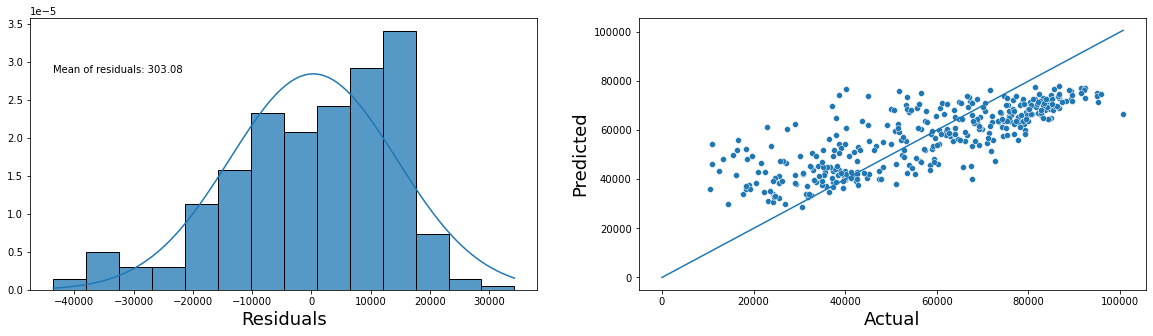

In [15]:
plot_model_evaluation(df_test, y_test)

#### Polynomial regression with ridge regularization

In [16]:
df_train, df_test, y_test, y_train, poly_model = fit_predict(df, calendar_features, model="polynomial", degree=2)

Training set R2 score: 0.8017856695866834
Test set R2 core: 0.6413896563115162
Test set MAPE: 25.30583313721657


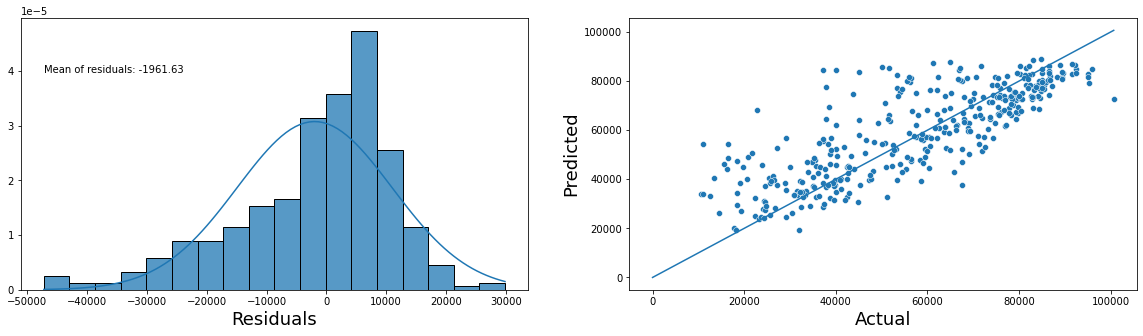

In [17]:
plot_model_evaluation(df_test, y_test)

# 6. Deployment

In [18]:
!pip install -U ibm-watson-machine-learning

## 6.1 Import and Install dependencies

In [27]:
from ibm_watson_machine_learning import APIClient
import json
import numpy as np

## 6.2 Authenticate and Set Space

In [28]:
wml_credentials = {
    "apikey":"YC6EV1zEQKBv6FeG_lWdRazX9jhuCNmVGn2SnqOFywbS",
    "url":"https://us-south.ml.cloud.ibm.com"
}

In [29]:
wml_client = APIClient(wml_credentials)
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -------------------------------------------------------------------  ------------------------
ID                                    NAME                                                                 CREATED
ca87fd4f-9547-4969-a396-94500d6a8016  openscale-express-path-preprod-7dd32e6c-849a-4f98-8dc7-5a56b3f620a4  2021-10-24T03:49:14.295Z
dd267fc3-ba20-4bfe-ace4-bab398eb35bb  openscale-express-path-7dd32e6c-849a-4f98-8dc7-5a56b3f620a4          2021-10-24T03:48:57.759Z
5a5e95fd-aafe-40b6-b261-b5f7eb4108b7  Latest Model Deployment                                              2021-10-24T01:33:14.301Z
e6d3576f-525e-463a-85fc-7d2458c6e839  Forecast Deployment                                                  2021-10-22T03:09:03.575Z
3be6605b-d5ef-41fa-8e02-c83009bf924f  openscale-express-path-preprod-dd4aea4e-8e7c-408d-843d-090f3bceeb32  2021-10-21T2

In [30]:
SPACE_ID="b0da1a7d-b07c-4551-9a34-467decf9605c"

In [31]:
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

## 6.3 Save and Deploy Model

In [24]:
MODEL_NAME = 'Visa App Forecast'
DEPLOYMENT_NAME = 'Visa Forecast Deploy'
BEST_MODEL = poly_model

In [32]:
# Set Python Version
software_spec_uid = wml_client.software_specifications.get_id_by_name('default_py3.7')

# Setup model meta
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}



In [157]:
# Set meta
deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME, 
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

# Deploy
deployment = wml_client.deployments.create(
    artifact_uid=model_uid, 
    meta_props=deployment_props 
)

# Output result
#deployment
#Save model
model_details = wml_client.repository.store_model(
    model=BEST_MODEL, 
    meta_props=model_props, 
    training_data=df_train, 
    training_target=y_train
)



#######################################################################################

Synchronous deployment creation for uid: '2d04d3f5-6463-4e48-af70-3aca79b98ff6' started

#######################################################################################


initializing
Note: Scikit-learn 0.23 framework with default_py3.7 software specification for Watson Machine Learning is deprecated. Use scikit-learn with  default_py3.7_opence software specification instead. For details, see https://dataplatform.cloud.ibm.com/docs/content/wsj/wmls/wmls-deploy-python-types.html.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f3112293-21af-47b9-9460-9c73693713e7'
------------------------------------------------------------------------------------------------




In [167]:
del df_test["count"]

In [169]:
df_test

,Year,Month,Week,Day,Day of Week,Day of Year,sin_doy,cos_doy,sin_dow,cos_dow,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
2032,2019,1,1,1,1,1,1.721336e-02,0.999852,0.781831,0.623490,...,0,0,0,0,0,0,0,0,0,0
2033,2019,1,1,2,2,2,3.442161e-02,0.999407,0.974928,-0.222521,...,0,0,0,0,0,0,0,0,0,0
2034,2019,1,1,3,3,3,5.161967e-02,0.998667,0.433884,-0.900969,...,0,0,0,0,0,0,0,0,0,0
2035,2019,1,1,4,4,4,6.880243e-02,0.997630,-0.433884,-0.900969,...,0,0,0,0,0,0,0,0,0,0
2036,2019,1,1,5,5,5,8.596480e-02,0.996298,-0.974928,-0.222521,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,2019,12,52,27,4,361,-6.880243e-02,0.997630,-0.433884,-0.900969,...,0,0,0,0,0,1,0,0,0,0
2393,2019,12,52,28,5,362,-5.161967e-02,0.998667,-0.974928,-0.222521,...,0,0,0,0,0,0,1,0,0,0
2394,2019,12,52,29,6,363,-3.442161e-02,0.999407,-0.781831,0.623490,...,0,0,0,0,0,0,0,1,0,0
2395,2019,12,1,30,0,364,-1.721336e-02,0.999852,0.000000,1.000000,...,0,0,0,0,0,0,0,0,1,0


## 6.4 Score Against Deployed Model

In [ ]:
deployment_uid = wml_client.deployments.get_uid(deployment)
payload = {"input_data":
           [
               {"fields":df_test.columns.to_numpy().tolist(), "values":df_test.to_numpy().tolist()}
           ]
          }
result = wml_client.deployments.score(deployment_uid, payload);  

In [ ]:
pred_values = np.squeeze(result['predictions'][0]['values']); pred_values
preddf = X_test.join(y_test)
preddf['Scores'] = pred_values
preddf.head()

In [ ]:
pred_values